<h1>Heisenberg Hamiltonian (1d & 2d)</h1>

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

<hr><hr>

This notebook provides a short introduction to circuit generation and resource analysis for Fermi-Hubbard model in one- and two-dimensions. Although emphasis is placed on circuits for quantum dynamics, components for state preparation and analysis methods are also critical in a realistic workflow.  Procedures that handle these tasks will be added later.

<b>WARNING:</b> <i>This notebook is an ALPHA release.  Although these methods represent (in part) the future of  pyLIQTR,  some components are unique to the ALPHA notebooks and they may be subject to change in a final release.  Be diligent when integrating these methods into existing workflows.</i>

<h2>Introduction</h2>


This notebook addresses resource estimation for the two-dimensional, spin-$1/2$ Heisenberg model:

\begin{equation}
H =   \sum_{\alpha, \langle jk; mn \rangle} J^\alpha_{jk,mn}\, (\sigma^\alpha_{jk} \otimes \sigma^\alpha_{mn}) + \sum_{\alpha, \langle jk\rangle} h^{\alpha}_{jk} \, \sigma^\alpha_{jk},
\end{equation}

Here we have introduced a compact notation $\sigma^\alpha$ for the Pauli spin matrices, with $\alpha \in \{x,y,z\}$, and use angle brackets to denote summation over sites $(j,k)$ of a 2-$d$ lattice.  The coupling between spin components at $(j,k)$ and $(m,n)$ is specified by the factors  $J^\alpha_{jk,mn}$, while local fields have a magnitude given by the $h^\alpha_{jk}$.  Although we have used pairs of indices to denote a two-dimensional system, the form of this Hamiltonian can be extended to any dimensionality.  For the purposes of discussion, we will nonetheless focus on an $M \times N$ rectangular lattice with uniform nearest-neighbor couplings and fields ($J^\alpha_{jk;mn} = J^\alpha$ and $h^{\alpha}_{jk} = h^\alpha$, respectively ).

While this model is two-dimensional, our qubit registers are often specified with one-dimensional indexing.  Fortuitously, there is a simple mapping that redefines this 2d Hamiltonian as a one-dimensional system with long-range spin-spin couplings.  To accomplish this we define a one-dimensional  path that snakes through the lattice:

<figure>
<center><img src = "./figures/heis_2d_mapping.png" width=900></center>
</figure>

This provides nearest-neighbor interactions within a row and longer-range, yet fixed-distance (specifically $N-1$), couplings down the columns of the lattice.  When recast in this manner the Hamiltonian becomes:

\begin{equation}
H = \sum_{\alpha \in \{x,y,z\}} H_\alpha,
\end{equation}

with the constituent terms,

\begin{equation}
H_\alpha =  \sum_{k=1}^{N(M-1)} J^\alpha \sigma^\alpha_k \otimes \sigma^\alpha_{k+N} + \sum_{j=0}^{M-1} \sum_{k=1}^{N-1} J^\alpha \sigma^\alpha_{j N + k} \otimes \sigma^\alpha_{j N + k + 1} + \sum_{k=1}^{N M} h^\alpha \sigma^\alpha_k.
\end{equation}




<hr>
<h2>Generating Hamiltonians</h2>

`pyLIQTR` can represent Hamiltonians as a sum of Pauli strings via the `lcu_strings` class.  The routines within this object can handle a variety of tasks, such as normalizing  Hamiltonians for use with QSP, generating matrix representations of the Hamiltonian operator, preparing input strings for circuit generation, consolidating repeated Pauli strings, or writing Hamiltonians to a volume for later use.  As one might surmise from its name, this class requires that the Hamiltonian  can be decomposed into a linear combination of unitary operators (LCU):

\begin{equation}
H = \sum_k \alpha_k U_k,
\end{equation}

where $U_k$ is a unitary operator and $\alpha_k \in \mathbb{R}$ is its associated coefficient.  This holds by construction for our 2-$d$ Heisenberg Hamiltonian.

To initiate our numerical approach, we must load a few required modules:

In [1]:
import numpy              as  np

import operator_strings   as  os
import hamiltonians       as  hams

<b>Note:</b> <i>Some of these imports are local (e.g., provided in this directory) and they might duplicate capabilities that are present elsewhere in `pyLIQTR`.  This is because the underlying changes are part of an ALPHA release - they not been integrated elsewhere.  Be cautious when calling functions with similar names or when passing arguments, as some functionality may have changed.  Note that all python scripts from this directory must be present when running this notebook or its derivatives.</i>


We also specify parameters for our Fermi-Hubbard example:

In [2]:
N_x = 4;         N_y = 4

J_x  = 0.4;      J_y  = 0.6;      J_z  =  1.0
h_x  = 0.5;      h_y  = 0.0;      h_z  = -1.0

The example above corresponds to an $M \times N = N_y \times N_x$ lattice, were the the $x$ spatial dimension is taken along the rows and $y$ down the columns. Note that the methods below can also generate a 1d Heisenberg chain with four sites if we set $N_x = 4$ and $N_y = 1$. 

The routine `hamiltonian_heisenberg_2d_strings` generates an `lcu_strings` object for the two-dimensional FH model.  

In [3]:
h2d_lcu = hams.hamiltonian_heisenberg_2d_strings( N_x, N_y,
                                                  J_x=J_x, J_y=J_y ,J_z=J_z,
                                                  h_x=h_x, h_y=h_y, h_z=h_z )

We can examine the terms in our Hamiltonian by calling  `print()`:

In [4]:
h2d_lcu.print()


Sites     	 Type 		 Coefficient
-------------------------------------------------------------------------------- 

(0, 1) 		 XX 		 0.4
(0, 1) 		 YY 		 0.6
(0, 1) 		 ZZ 		 1.0
(1, 2) 		 XX 		 0.4
(1, 2) 		 YY 		 0.6
(1, 2) 		 ZZ 		 1.0
(2, 3) 		 XX 		 0.4
(2, 3) 		 YY 		 0.6
(2, 3) 		 ZZ 		 1.0
(4, 5) 		 XX 		 0.4
(4, 5) 		 YY 		 0.6
(4, 5) 		 ZZ 		 1.0
(5, 6) 		 XX 		 0.4
(5, 6) 		 YY 		 0.6
(5, 6) 		 ZZ 		 1.0
(6, 7) 		 XX 		 0.4
(6, 7) 		 YY 		 0.6
(6, 7) 		 ZZ 		 1.0
(8, 9) 		 XX 		 0.4
(8, 9) 		 YY 		 0.6
(8, 9) 		 ZZ 		 1.0
(9, 10) 		 XX 		 0.4
(9, 10) 		 YY 		 0.6
(9, 10) 		 ZZ 		 1.0
(10, 11) 		 XX 		 0.4
(10, 11) 		 YY 		 0.6
(10, 11) 		 ZZ 		 1.0
(12, 13) 		 XX 		 0.4
(12, 13) 		 YY 		 0.6
(12, 13) 		 ZZ 		 1.0
(13, 14) 		 XX 		 0.4
(13, 14) 		 YY 		 0.6
(13, 14) 		 ZZ 		 1.0
(14, 15) 		 XX 		 0.4
(14, 15) 		 YY 		 0.6
(14, 15) 		 ZZ 		 1.0
(0, 4) 		 XX 		 0.4
(0, 4) 		 YY 		 0.6
(0, 4) 		 ZZ 		 1.0
(1, 5) 		 XX 		 0.4
(1, 5) 		 YY 		 0.6
(1, 5) 		 ZZ 		 1.0
(2, 6) 		 XX 		 0

()

This table enumerates each term in the Hamiltonian (LCU) on a separate line.  Note that site indexing proceeds from zero $-$ contrasting with our derivation above $-$ since we now follow python numbering conventions.  Sequential chunks of this output correspond to Pauli strings for different segments of the Hamiltonian.  These follow a designated order:

1. Row spin coupling
2. Column spin coupling
3. External fields


For instance, the  coupling between the first two spin sites is:


\begin{equation}
J^x \, X_0 \otimes X_1   +   J^y \, Y_0 \otimes Y_1   +    J^z \, Z_0 \otimes Z_1,
\end{equation}

which corresponds to the lines:

<!-- <center> -->


    Sites     	 Type 		 Coefficient
    --------------------------------------------

    (0, 1) 		 XX 		 0.5   
    (0, 1) 		 YY 		 0.5
    (0, 1) 		 ZZ 		 1.0
    
    
<!-- </center> -->

When considering non-Heisenberg Hamiltonians we might also see `+` and `-` appearing in the strings, which designate to the $Z$ eigenvalue projectors $P_{Z+} = (I + Z)/2$ and $P_{Z-} = (I - Z)/2$.  In other cases, certain terms may have a coefficient of zero.  The `lcu_strings` class contains routines `expand_projectors()` and `remove_zeros()`, which expand the projectors and remove the zero terms, respectively.  There is also a routine `cleanup()` that performs both of these tasks when necessary (this is not needed for this model, but we show it anyway):


In [5]:
h2d_lcu.cleanup()
h2d_lcu.print()


Sites     	 Type 		 Coefficient
-------------------------------------------------------------------------------- 

(0, 1) 		 XX 		 0.4
(0, 1) 		 YY 		 0.6
(0, 1) 		 ZZ 		 1.0
(1, 2) 		 XX 		 0.4
(1, 2) 		 YY 		 0.6
(1, 2) 		 ZZ 		 1.0
(2, 3) 		 XX 		 0.4
(2, 3) 		 YY 		 0.6
(2, 3) 		 ZZ 		 1.0
(4, 5) 		 XX 		 0.4
(4, 5) 		 YY 		 0.6
(4, 5) 		 ZZ 		 1.0
(5, 6) 		 XX 		 0.4
(5, 6) 		 YY 		 0.6
(5, 6) 		 ZZ 		 1.0
(6, 7) 		 XX 		 0.4
(6, 7) 		 YY 		 0.6
(6, 7) 		 ZZ 		 1.0
(8, 9) 		 XX 		 0.4
(8, 9) 		 YY 		 0.6
(8, 9) 		 ZZ 		 1.0
(9, 10) 		 XX 		 0.4
(9, 10) 		 YY 		 0.6
(9, 10) 		 ZZ 		 1.0
(10, 11) 		 XX 		 0.4
(10, 11) 		 YY 		 0.6
(10, 11) 		 ZZ 		 1.0
(12, 13) 		 XX 		 0.4
(12, 13) 		 YY 		 0.6
(12, 13) 		 ZZ 		 1.0
(13, 14) 		 XX 		 0.4
(13, 14) 		 YY 		 0.6
(13, 14) 		 ZZ 		 1.0
(14, 15) 		 XX 		 0.4
(14, 15) 		 YY 		 0.6
(14, 15) 		 ZZ 		 1.0
(0, 4) 		 XX 		 0.4
(0, 4) 		 YY 		 0.6
(0, 4) 		 ZZ 		 1.0
(1, 5) 		 XX 		 0.4
(1, 5) 		 YY 		 0.6
(1, 5) 		 ZZ 		 1.0
(2, 6) 		 XX 		 0

()

We can also generate the matrix representation of  this Hamiltonian operator using `matrix()`.  Only do this for small Hamiltonians ( $N = 4$ or so the 2d Heisenberg model) since the operation becomes exponentially costly with increasing $N$:

In [6]:
# H = h2d_lcu.matrix()

Finally, we can get the Hamiltonian in a form that is used by `pyLIQTR` for circuit generation.  The `strings()` function generates a set of tuples, each containing an identity-padded Pauli string for a term in the LCU as well as the corresponding coefficient.  Be sure to call `cleanup()` before invoking this routine if circuit generation is the objective (in addition, it will often be necessary to rescale $H$ - see below).

In [7]:
h2d_lcu.strings()

[('XXIIIIIIIIIIIIII', 0.4),
 ('YYIIIIIIIIIIIIII', 0.6),
 ('ZZIIIIIIIIIIIIII', 1.0),
 ('IXXIIIIIIIIIIIII', 0.4),
 ('IYYIIIIIIIIIIIII', 0.6),
 ('IZZIIIIIIIIIIIII', 1.0),
 ('IIXXIIIIIIIIIIII', 0.4),
 ('IIYYIIIIIIIIIIII', 0.6),
 ('IIZZIIIIIIIIIIII', 1.0),
 ('IIIIXXIIIIIIIIII', 0.4),
 ('IIIIYYIIIIIIIIII', 0.6),
 ('IIIIZZIIIIIIIIII', 1.0),
 ('IIIIIXXIIIIIIIII', 0.4),
 ('IIIIIYYIIIIIIIII', 0.6),
 ('IIIIIZZIIIIIIIII', 1.0),
 ('IIIIIIXXIIIIIIII', 0.4),
 ('IIIIIIYYIIIIIIII', 0.6),
 ('IIIIIIZZIIIIIIII', 1.0),
 ('IIIIIIIIXXIIIIII', 0.4),
 ('IIIIIIIIYYIIIIII', 0.6),
 ('IIIIIIIIZZIIIIII', 1.0),
 ('IIIIIIIIIXXIIIII', 0.4),
 ('IIIIIIIIIYYIIIII', 0.6),
 ('IIIIIIIIIZZIIIII', 1.0),
 ('IIIIIIIIIIXXIIII', 0.4),
 ('IIIIIIIIIIYYIIII', 0.6),
 ('IIIIIIIIIIZZIIII', 1.0),
 ('IIIIIIIIIIIIXXII', 0.4),
 ('IIIIIIIIIIIIYYII', 0.6),
 ('IIIIIIIIIIIIZZII', 1.0),
 ('IIIIIIIIIIIIIXXI', 0.4),
 ('IIIIIIIIIIIIIYYI', 0.6),
 ('IIIIIIIIIIIIIZZI', 1.0),
 ('IIIIIIIIIIIIIIXX', 0.4),
 ('IIIIIIIIIIIIIIYY', 0.6),
 ('IIIIIIIIIIIIIIZZ'

<hr>
<h2>Generating Circuits</h2>

<b>Step 1: Operator Rescaling</b>

QSP-based simulations require a block encoding for the Hamiltonian $H$, which is only well-defined if $H$ satisfies the norm condition $|| H || \leq 1$.  Since we are using an LCU as input, it is convenient to rescale this operator so that $H \mapsto H / \alpha$, where $\alpha = \sum_j | \alpha_j |$ is a 1-norm defined by its coefficients.   To apply this, we will create an `lcu_strings` object for a Fermi-Hubbard instance:

In [8]:
N_x = 2;         N_y = 2

J_x  = 0.5;      J_y  = 0.5;      J_z  =  1.0
h_x  = 0.5;      h_y  = 0.0;      h_z  = -1.0

h2d_lcu = hams.hamiltonian_heisenberg_2d_strings( N_x, N_y,
                                                  J_x=J_x, J_y=J_y ,J_z=J_z,
                                                  h_x=h_x, h_y=h_y, h_z=h_z )

We then perform cleanup and  rescaling via:

In [9]:
h2d_lcu.cleanup()

norm_0 = h2d_lcu.get_coeff_norm()
h2d_lcu.rescale_coeff_norm()
norm_1 = h2d_lcu.get_coeff_norm()

print("Norm before rescaling:  ", norm_0)
print("Norm after rescaling:   ", norm_1)

print("Rescaling factor", h2d_lcu.get_alpha())

Norm before rescaling:   14.0
Norm after rescaling:    0.9999999999999998
Rescaling factor 14.0


The rescaling factor is saved in the `lcu_strings` object (immutably after the first rescaling call), and it is accessible via `get_alpha()`. We must similarly rescale our timesteps so dynamics generated by the propagator $\exp[-\imath H t] = \exp[\imath (H/\alpha) \cdot (\alpha t)]$ remain invariant:

In [10]:
alpha = h2d_lcu.get_alpha()                   # Hamiltonian rescaling factor

t_max = 0.05                                  # maximal simulation time
dt    = 0.01                                  # sampling timestep

tvec     =   np.arange(0,t_max+dt,dt)         # vector of times to sample
tvec_rs  =   tvec*alpha                       # rescaled timesteps

For now, we will skip the operator-level analysis of the QSP sequence and move directly to circuit generation.  This 4x4 instance has already crossed beyond a trivial execution time, and simulations are best conducted using more sophisticated computational techniques (these will be provided later using auxiliary notebooks, scripts, and reference data).

<b>Step 2: Circuit generation.</b>

We approach circuit generation by loading the required components of `pyLIQTR`:

In [11]:

import cirq

from   cirq.contrib.svg        import SVGCircuit

from   pyLIQTR.QSP             import gen_qsp         as   qspFuncs
from   pyLIQTR.QSP             import QSP             as   pQSP
from   pyLIQTR.QSP.gen_qsp     import QSP_Simulator

from   pyLIQTR.QSP.Hamiltonian import Hamiltonian     as pyH
from   pyLIQTR.QSP.qsp_helpers import get_state_vector
from   pyLIQTR.QSP.qsp_helpers import qsp_decompose_once, print_to_openqasm, prettyprint_qsp_to_qasm 

from   pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform


The LCU that we constructed above must transferred into a dedicated Hamiltonian object for use with `pyLIQTR`'s circuit generation methods.  We do this by calling `pyLIQTR.QSP.Hamiltonian` (which we have aliased as `pyH`) with the rescaled input set: 

In [12]:
lcu_string_set  =  h2d_lcu.strings()
qsp_H           =  pyH(lcu_string_set)

The next step is to generate QSP phase angles for our time evolution.  A dedicated set of routines in the circuit-generation code handles this task (though they will soon be deprecated in favor of the methods in `Angler`).  Unfortunately these methods can become cumbersome for large problems, at high precision, or for long timesteps.  If we are not interested in simulating the circuit $-$ but only in performing resource analysis $-$ we do not need to compute the actual phases. Instead, we can use analytical bounds to estimate an equivalent number $N_\text{phi}$ of random phases.  This requires the use of an additional keyword (`mode="random"`) in our input:


In [13]:
required_precision = 1e-2

angles = []

for t in tvec_rs:
    angles.append(qspFuncs.compute_hamiltonian_angles(qsp_H, t, required_precision, mode="random")[0])


print ("time","\t","# of required phases")
print ("===============================")
for n in range(len(tvec)):
    print(tvec[n], "\t", len(angles[n]))

time 	 # of required phases
0.0 	 1
0.01 	 5
0.02 	 9
0.03 	 9
0.04 	 9
0.05 	 9


/Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2416: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


A QSP circuit with $N_\text{phi}$ phase angles contains $N_\text{phi} - 1$ repetitions of the Select oracle, which constitues the majority of our computational overhead.  To first order, we can perform an analysis for a single iterate and scale this the number of repetitions.  This is much more efficient than generating the full circuit.

In [14]:
qsp_generator   = pQSP.QSP(phis=angles[1], hamiltonian=qsp_H, target_size=qsp_H.problem_size)
curr_circ       = qsp_generator.circuit()

#SVGCircuit(curr_circ)      # uncomment to view circuit

The nature of this repetition is made apparent by decomposing the circuit further:

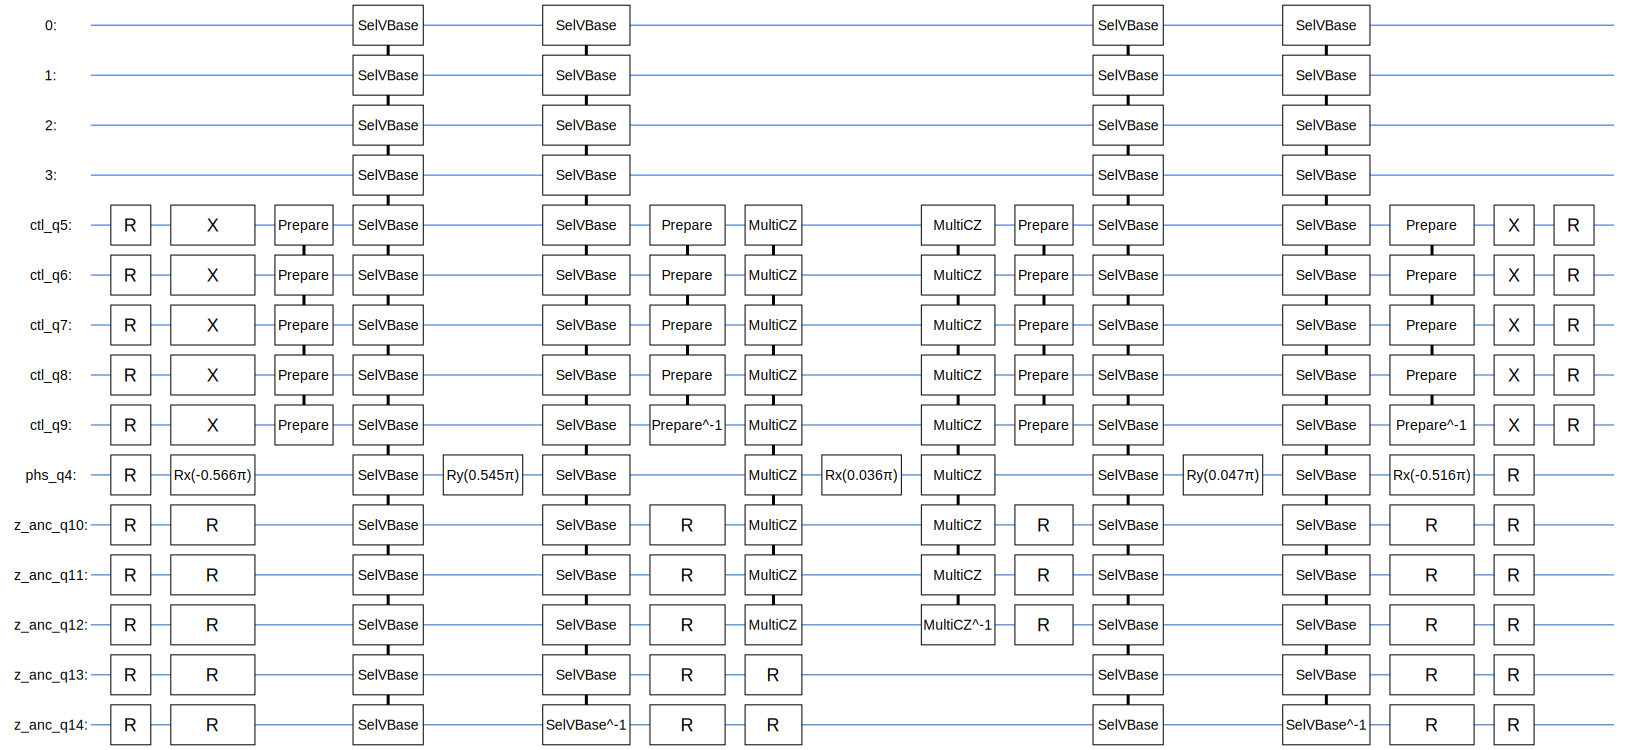

In [15]:
decomposed_circuit       = cirq.align_left(qsp_decompose_once(curr_circ))

SVGCircuit(decomposed_circuit)      # uncomment to view circuit

 As a general rule, we will see $N_\text{phi} - 1$ instances of `SelVBase` and `Prepare` (each) and $N_\text{phi} - 3$ repetitions of `MultiCZ` for a circuit containing $N_\text{phi}$ phases.  The remainder are single-qubit Pauli operations.  
 
 We will demonstrate a subcircuit analysis for  `Prepare`-`SelVBase` segment and a `MultiCZ` segment.  In the first stage, we decompose the circuit down to controlled operations (CNOT, Toffolis, etc.):

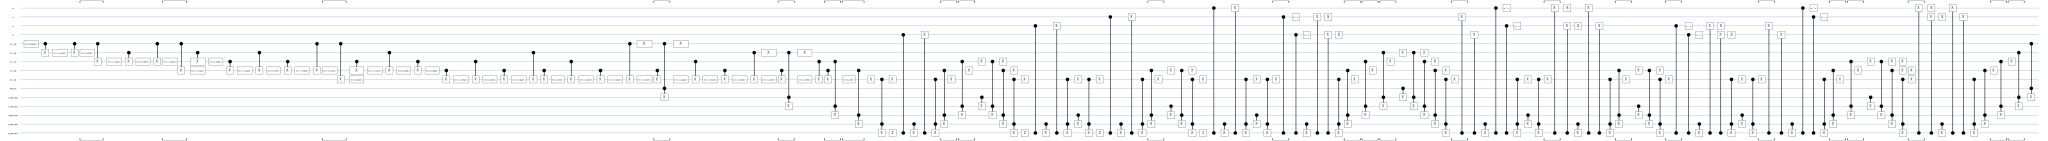

In [16]:
circ_selv_prep         =  decomposed_circuit[2:4]
circ_selv_prep_cops    =  cirq.align_left(qsp_decompose_once(circ_selv_prep))

SVGCircuit(circ_selv_prep_cops)      # uncomment to view circuit

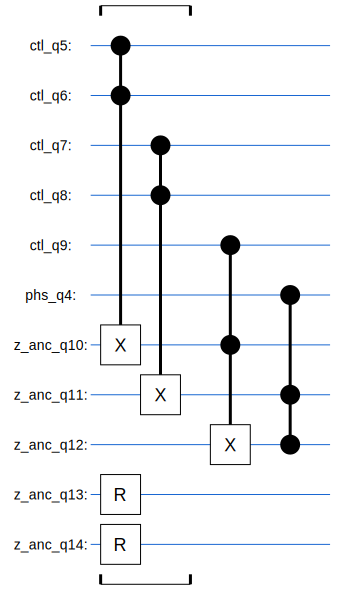

In [17]:
circ_multicz           =  decomposed_circuit[7:8]
circ_multicz_cops      =  cirq.align_left(qsp_decompose_once(circ_multicz))

SVGCircuit(circ_multicz_cops)      # uncomment to view circuit

Next,we transform into the Clifford+$T$ gate set (Note: this can take a while, even when instances are only a bit larger than our demostration scale):

In [18]:
circ_selv_prep_cliff_t    = cirq.align_left(clifford_plus_t_direct_transform(circ_selv_prep_cops))
circ_multicz_cliff_t      = cirq.align_left(clifford_plus_t_direct_transform(circ_multicz_cops))

SVGCircuit(circ_selv_prep_cliff_t)

We can assess the $T$ count for these circuits using `get_t_counts`:

In [19]:
import resource_analysis as ran

svp_nt,svp_ntinv = ran.get_t_counts(circ_selv_prep_cliff_t)
mcz_nt,mcz_ntinv = ran.get_t_counts(circ_multicz_cliff_t)

And similarly calculate the gate depth:

In [20]:
depth_selv_prep_cops      =  ran.get_gate_depth(circ_selv_prep_cops)
depth_selv_prep_cliff_t   =  ran.get_gate_depth(circ_selv_prep_cliff_t)

depth_multicz_cops        =  ran.get_gate_depth(circ_multicz_cops)
depth_multicz_cliff_t     =  ran.get_gate_depth(circ_multicz_cliff_t)

Finally printing the statistics:

In [21]:
print()
print("Prepare + Select\n================================")
print(" Clifford+T Depth:\t", depth_selv_prep_cliff_t)
print(" T Count:\t\t", svp_nt)
print(" T^dag Count:\t\t", svp_ntinv)
print(" T Total:\t\t", svp_nt + svp_ntinv)

print("\n")
print("MultiCZ\n================================")
print(" Clifford+T Depth:\t", depth_multicz_cliff_t)
print(" T Count:\t\t", mcz_nt)
print(" T^dag Count:\t\t", mcz_ntinv)
print(" T Total:\t\t", mcz_nt + mcz_ntinv)



Prepare + Select
 Clifford+T Depth:	 7245
 T Count:		 3076
 T^dag Count:		 184
 T Total:		 3260


MultiCZ
 Clifford+T Depth:	 30
 T Count:		 12
 T^dag Count:		 16
 T Total:		 28
